# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]

BananaBrain


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [ ]:
env.close()

### 4.Double-DQN Agent with Prioritized Experience Replay

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import os
import sys
import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [8]:
class SumTree(object):
    '''
     code apdated from https://raw.githubusercontent.com/takoika/PrioritizedExperienceReplay/master/sum_tree.py
    '''
    def __init__(self, max_size):
        self.max_size = max_size
        self.tree_level = math.ceil(math.log(max_size+1, 2))+1
        self.tree_size = 2**self.tree_level-1
        self.tree = [0. for i in range(self.tree_size)]
        self.data = [None for i in range(self.max_size)]
        self.size = 0
        self.cursor = 0

    def add(self, contents, value):
        index = self.cursor
        self.cursor = (self.cursor+1)%self.max_size
        self.size = min(self.size+1, self.max_size)

        self.data[index] = contents
        self.val_update(index, value)

    def get_val(self, index):
        tree_index = 2**(self.tree_level-1)-1+index
        return self.tree[tree_index]

    def val_update(self, index, value):
        tree_index = 2**(self.tree_level-1)-1+index
        diff = value-self.tree[tree_index]
        self.reconstruct(tree_index, diff)

    def reconstruct(self, tindex, diff):
        self.tree[tindex] += diff
        if not tindex == 0:
            tindex = int((tindex-1)/2)
            self.reconstruct(tindex, diff)
    
    def find(self, value, norm=True):
        '''
           value: relative of the sum at the root (0-1)
        '''
        #print('In find value, root value, tree level ', value, self.tree[0], self.tree_level)
        if isinstance(self.tree[0], complex): raise ValueError('root of tree in find is complex ', self.tree[0])
        if isinstance(value, complex): raise ValueError('value in find is complex ', value)
        if norm:
            value *= self.tree[0]
        return self._find(value, 0)

    def _find(self, value, index):
        '''
            return 
              value of data
              value stored in tree which in this case the priority
              index to data
        '''
        if 2**(self.tree_level-1)-1 <= index:
            #print(self.tree_level, 2**(self.tree_level-1)-1)
            return self.data[index-(2**(self.tree_level-1)-1)], self.tree[index], index-(2**(self.tree_level-1)-1)

        left = self.tree[2*index+1]
        #print('In _find, left, value ', left, value)

        if value <= left:
            return self._find(value,2*index+1)
        else:
            return self._find(value-left,2*(index+1))
        
    def print_tree(self):
        for k in range(1, self.tree_level+1):
            for j in range(2**(k-1)-1, 2**k-1):
                print(self.tree[j], end=' ')
            print()

    def filled_size(self):
        return self.size

In [10]:
class ReplayMemory(object):
    """ 

    see https://arxiv.org/pdf/1511.05952.pdf .

    """
    
    def __init__(self, memory_size, batch_size, alpha, seed, device):
        """
        Parameters
        ----------
        memory_size (int): sample size to be stored
        batch_size (int): batch size to be selected by `select` method
        alpha (float): determine the degree of priorization used in sampling the buffer: 
            0 for uniform random, 
            1 for pure priority based selection
            Prob_i \sim priority_i**alpha/sum(priority**alpha)
        seed (int): initialization value for random generators
        device (string): pytorch-based computation device: cpu or cuda 
        """
        random.seed(seed)
        np.random.seed(seed)
        
        self.tree = SumTree(memory_size)
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.alpha = alpha
        self.device = device

    def add(self, state, action, reward, next_state, done, priority):
        """
        Add a new experience.
        
        Parameters
        ----------
        state (37-element float list): current state of environment (at time t)
        action (int): action applied at time t
        reward (float): reward returned by the environment at time t+1
        next_state (37-element float list): next state of environment (at time t+1)
        done (bool): whether the episode ends
        priority (float): priority of this experience (state, action, reward, next_state, done)
        """
        e = self.experience(state, action, reward, next_state, float(np.uint8(done)))
        if isinstance(priority, complex): raise ValueError('In ReplayMem::add, Priority is complex ', priority)
        if isinstance(self.alpha, complex): raise ValueError('In ReplayMem::add, self.alpha is complex ', self.alpha)
        if isinstance(priority**self.alpha, complex): 
            raise ValueError('In ReplayMem::add, priority {} ** self.alpha {} = {} is complex '.format(priority,
                                                    self.alpha, priority**self.alpha))
                                                                       
        self.tree.add(e, float(priority**self.alpha))

    def select(self, beta):
        """ 
        Randomly sampling the experiences in the replay memory: the degree of randomness is determined by self.alpha.
        The degree/strength of important sampling weights is determined by beta
        
        Parameters
        ----------
        beta (float) : strength of correction (annealing) for non-uniform sampling, default 0.5
                       value should gradually increase to 1. at the end of learning (the q-value converges)
        
        Returns
        -------
        states (floating tensor): torch tensor of size [batch_size, 37]
        actions (long tensor): torch tensor of size [batch_size, 1]
        rewards (floating tensor): : torch tensor of size [batch_size, 1]
        next_states (floating tensor): torch tensor of size [batch_size, 37]
        dones (floating tensor): : torch tensor of size [batch_size, 1]
        weights (floating tensor): : torch tensor of size [batch_size, 1] for important sampling weights
        indices (list): indices of sample sampled from the replay memory (i.e., sample positions in a sum tree)
        """
        
        if self.tree.filled_size() < self.batch_size:
            return None, None, None, None, None, None, None

        states = [None]*self.batch_size
        actions = [None]*self.batch_size
        rewards = [None]*self.batch_size
        next_states = [None]*self.batch_size
        dones = [None]*self.batch_size
        
        indices = [None]*self.batch_size
        weights = np.zeros(self.batch_size, dtype=np.float32)
        priorities = [None]*self.batch_size
        for bidx in range(self.batch_size):
            r = np.random.uniform()
            data, priority, index = self.tree.find(r)
            priorities[bidx] = priority
            weights[bidx] = (1./self.filled_size()/priority)**beta if priority > 1e-16 else 0
            indices[bidx] = index
            states[bidx] = data.state
            actions[bidx] = data.action
            rewards[bidx] = data.reward
            next_states[bidx] = data.next_state
            dones[bidx] = data.done
            self.priority_update([index], [0]) # To avoid duplicating
            
        
        self.priority_update(indices, priorities) # Revert priorities
        if not np.isclose(np.amax(weights), 0.):
            weights /= np.amax(weights) # Normalize for stability
        
        # convert to torch 
        states = torch.from_numpy(np.vstack(states)).float().to(self.device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(self.device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(self.device)
        dones = torch.from_numpy(np.vstack(dones)).float().to(self.device)
        weights = torch.from_numpy(np.vstack(weights)).float().to(self.device)
        
        return states, actions, rewards, next_states, dones, weights, indices

    def priority_update(self, indices, priorities):
        """ 
        Update priorities of samples already stored in the replay memory.
        
        Parameters
        ----------
        indices (list): indices of sample sampled from the replay memory (i.e., sample positions in a sum tree)
        """
        for i, p in zip(indices, priorities): self.tree.val_update(i, float(p**self.alpha))
    

    def __len__(self):
        """Size of the replay memory."""
        return self.tree.filled_size()
    

In [18]:
class QNetwork(nn.Module):
    '''
        Deep neural network for approximation of q-values
    '''
    
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64, fc3_units=32):
        '''
            Parameters
            ----------
            state_size (int) : size of each state (37)
            action_size (int) : dimension of action space (number of possible actions in each state)
            fc1_units (int): output channels of the 1st fully connected layer
            fc2_units (int): output channels of the 2nd fully connected layer
            fc3_units (int): output channels of the 3rd fully connected layer
        '''
        
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [12]:
class Agent():

    def __init__(self, device, state_size, action_size, seed, buffer_size=int(1e5),priority_eps=1e-3,
                 replay_alpha= 0.7, batch_size=64, gamma=0.99, update_every=4, tau=1e-3, 
                 lr=5e-4,optim_step_size=500, optim_gamma=0.8, is_train=True):
        
        '''
            Parameters
            ----------
            device (string): pytorch-based computation device: cpu or cuda 
            state_size (int) : size of each state (37)
            action_size (int) : dimension of action space (number of possible actions in each state)
            seed (int): initialization value for random generators
            buffer_size (int): sample size to be stored
            priority_eps (float): a minimum value of priorities (small value added to priorities) 
            replay_alpha (flaot): determine the degree of priorization used in sampling the buffer: 
                0 for uniform random, 
                1 for pure priority based selection
                Prob_i \sim priority_i**alpha/sum(priority**alpha)
            batch_size (int): batch size of experiences used to train the agent
            gamma (float): a reward discount rate
            update_every (int): period to which a target q-network gets updated from a behavior q-network 
            tau (float): weights for weighted average of the parameter values of the target q-network and the behavior network 
            lr (float): agent learning rate
            optim_step_size (int): number of step at which the learning rate gets updated
            optim_gamma (float): factor to which learning rate is adjusted
            is_train (bool): whether the agent is in training mode
        '''
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        
        self.device = device
        self.action_size = action_size
        self.is_train = is_train
        
        self.behavior_qnet = QNetwork(state_size, action_size, seed).to(self.device)
        self.target_qnet = QNetwork(state_size, action_size, seed).to(self.device)
        self.memory = ReplayMemory(buffer_size, batch_size, replay_alpha, seed, self.device)
        
        self.priority_eps = priority_eps
        self.lr = lr
        self.grad_abs_max = []
        self.grad_abs_min = []
        self.optimizer = optim.Adam(self.behavior_qnet.parameters(), self.lr)
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=optim_step_size, gamma=optim_gamma)
        
        self.batch_size = batch_size
        self.gamma = gamma # discount rate
        self.update_every = update_every
        self.tau = tau
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done, beta):
        """
        Add a new experience to the replay memory and train the agent.
        
        Parameters
        ----------
        state (37-element float list): current state of environment (at time t)
        action (int): action applied at time t
        reward (float): reward returned by the environment at time t+1
        next_state (37-element float list): next state of environment (at time t+1)
        done (bool): whether the episode ends
        priority (float): priority of this experience (state, action, reward, next_state, done)
        beta (float) : strength of correction (annealing) for non-uniform sampling, default 0.5
                       value should gradually increase to 1. at the end of learning (the q-value converges)
        """
        # save experience
        if isinstance(reward, complex): raise ValueError('Reward is complex ', reward)
        self.memory.add(state, action, reward, next_state, done, (np.abs(reward)+self.priority_eps) )
        
        # learn every update_every step
        self.t_step = (self.t_step+1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.select(beta)
                self.learn(experiences)
                
    def learn(self, experiences):
        
        """
        Learn from experiences
        
        Parameters
        ----------
        experiences (tuple): containing 
            states (floating tensor): torch tensor of size [batch_size, 37]
            actions (long tensor): torch tensor of size [batch_size, 1]
            rewards (floating tensor): : torch tensor of size [batch_size, 1]
            next_states (floating tensor): torch tensor of size [batch_size, 37]
            dones (floating tensor): : torch tensor of size [batch_size, 1]
            weights (floating tensor): : torch tensor of size [batch_size, 1] for important sampling weights
            indices (list): indices of sample sampled from the replay memory (i.e., sample positions in a sum tree)
        """
        
        # decompose experiences
        states, actions, rewards, next_states, dones, weights, indices = experiences
        
        # prepare gradient calculation
        self.optimizer.zero_grad()
        self.behavior_qnet.zero_grad()
        
        priorities = [None]*self.batch_size
        for isx, state in enumerate(states):
            
             # get current estimate of q values
            q_estimate = self.behavior_qnet(state)[actions[isx]]
        
            # get target q values
            with torch.no_grad():
                max_q_index = self.behavior_qnet(next_states[isx]).argmax().unsqueeze(0)
                q_target_next = self.target_qnet(next_states[isx])[max_q_index]
                q_target = rewards[isx] + (self.gamma * q_target_next * (1.-dones[isx]))
        
            # compute differences
            loss = F.smooth_l1_loss(q_estimate, q_target.detach())
            td_err = torch.abs(q_estimate.detach() - q_target.detach()) + self.priority_eps
            
             # update this transition
            if np.isnan(td_err.numpy()) or np.isinf(td_err.numpy()): 
                raise ValueError('Priority computed fron learn is Nan or Inf ', td_err.numpy())
                
            priorities[isx] = td_err
            
            # accumulate weighted*gradient changes
            loss.backward()
            grad_abs_max, grad_abs_min = [],[]
            for p in self.behavior_qnet.parameters():
                p.grad.data *= weights[isx]
                grad_abs_max.append(np.amax(np.abs(p.grad.detach().numpy().flatten())))           
                grad_abs_min.append(np.amin(np.abs(p.grad.detach().numpy().flatten())))
                
            self.grad_abs_max.append(max(grad_abs_max))
            self.grad_abs_min.append(min(grad_abs_min))

        # update network parameters
        self.optimizer.step()
        
        # update memory
        self.memory.priority_update(indices, priorities)
    
        # ------------------- update target network ------------------- #
        self.soft_update_target_net_params()
        
    def soft_update_target_net_params(self):
        '''
            θ_target = τ*θ_local + (1 - τ)*θ_target
        '''
        for target_param, local_param in zip(self.target_qnet.parameters(), self.behavior_qnet.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.-self.tau)*target_param.data)

    def action_prob(self, q_values, eps):
        
        """
        Determine an epsilon greedy policy
        
        Parameters
        ----------
        q_values (floating tensor): q-values associated with each action (size [1, 4]) 
        eps (float): the degree of randomness in selecting actions
         
        """        
        
        probs = None
        
        if np.isclose(eps, 0.) and self.is_train:
            probs = np.ones(self.action_size, dtype=np.float32) / float(self.action_size)
        else:
            probs = np.ones(self.action_size, dtype=np.float32) * eps / float(self.action_size)
            probs[q_values.argmax(dim=1).item()] = 1. - eps + eps / float(self.action_size)
        return probs
    
    def act(self, state, eps=0.):
        """
        Determine an action at state
        
        Parameters
        ----------
        state (floating tensor): a current environment state (size [1, 37]) 
        eps (float): the degree of randomness in selecting actions
         
        """          
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.behavior_qnet.eval()
        with torch.no_grad():
            q_values = self.behavior_qnet(state)
        if self.is_train: self.behavior_qnet.train()
        
        if np.isclose(eps, 0.) and not self.is_train:
            return q_values.argmax(dim=1).item()
        else:
            return np.random.choice(np.arange(self.action_size), replace=False, p=self.action_prob(q_values, eps))
        
        

### 5 Train DDQN Agent with Prioritized Experience Replay

In [16]:
# Train dqn
def dqn(env, agent, train_mode=True, n_episodes=2000, max_t=1000, eps_start=1.,eps_end=0.01,eps_decay=0.995,
        beta_reverse=0.5, beta_reverse_decay = 0.99):
    
        """
        
        Parameters
        ----------
        env (Unity object): environment 
        agent (Agent): DQN agent
        train_mode (bool): whether run in a train mode
        n_episodes (int): number of episodes
        max_t (int): a maximum time-step in each episode
        eps_start (float): start value for epsilon for epsilon greedy policies
        eps_end (float): end value for epsilon for epsilon greedy policies
        eps_decay (float): update factor of epsilon
        beta_reverse (float): start value for beta
        beta_reverse_decay (float): amount at which beta-reverse reduced, 
            beta = 1.-max(beta_reverse_decay*beta_reverse, 0.)
        """
        
    # environment
    brain_name = env.brain_names[0]
    

    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    beta = beta_reverse
    for i_episode in range(n_episodes):

        env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
        state = env_info.vector_observations[0] # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done, beta)

            state=next_state
            score+=reward
            if done: break
                
        # update score
        scores_window.append(score)
        scores.append(score)
        # update epsilon
        eps = max(eps_end, eps_decay*eps)
        # update beta
        if i_episode > n_episodes//2:
            beta_reverse *= beta_reverse_decay
            beta = 1.-max(beta_reverse, 0.)
            
        print('\rEpisode {}\tAverage score {:.2f} \teps {} \tbeta {}'.format(i_episode, np.mean(scores_window), eps, beta), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage score {:.2f} \teps  {} \tbeta {}'.format(i_episode, np.mean(scores_window), eps, beta))
        if np.mean(scores_window) >= 13.:
            print('\Environment solved in {:d} episodes!\tAverage score {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.behavior_qnet.state_dict(), 'checkpoint_13_2.pth')
            break
    return scores

Episode 0	Average score 1.00 	eps  0.995 	beta 0.5
Episode 100	Average score 0.54 	eps  0.6027415843082742 	beta 0.5
Episode 200	Average score 3.30 	eps  0.36512303261753626 	beta 0.5
Episode 300	Average score 4.99 	eps  0.2211807388415433 	beta 0.5
Episode 400	Average score 7.31 	eps  0.13398475271138335 	beta 0.5
Episode 500	Average score 8.85 	eps  0.0811640021330769 	beta 0.5
Episode 600	Average score 10.40 	eps  0.04916675299948831 	beta 0.5
Episode 700	Average score 11.05 	eps  0.029783765425331846 	beta 0.5
Episode 800	Average score 10.86 	eps  0.02 	beta 0.539702 	beta 0.5
Episode 900	Average score 11.57 	eps  0.02 	beta 0.5
Episode 1000	Average score 12.17 	eps  0.02 	beta 0.5
Episode 1100	Average score 12.37 	eps  0.02 	beta 0.5
Episode 1159	Average score 13.01 	eps 0.02 	beta 0.5\Environment solved in 1059 episodes!	Average score 13.01


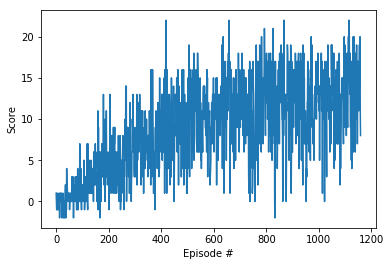

In [24]:
# computing device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# environment
brain_name = env.brain_names[0]
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
action_size = env.brains[brain_name].vector_action_space_size
state_size = env_info.vector_observations.size

# agent
seed = 0
agent = Agent(device, state_size, action_size, seed, buffer_size=int(1e5),priority_eps=1e-3,
                 replay_alpha= 0.7, batch_size=64, gamma=0.99, update_every=4, tau=1e-3, 
                 lr=5e-4,optim_step_size=500, optim_gamma=0.8)

# DDQN with prioritized experience replay
scores = dqn(env, agent, train_mode=True, n_episodes=3500, max_t=2000, eps_start=1.,eps_end=0.02,eps_decay=0.995,
        beta_reverse=0.5, beta_reverse_decay=0.9995)

# close environment 
env.close()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()